In [1]:
# Vorgehen nach Box-Jenkins Methode
import numpy as np
from pandas import read_csv
import pandas as pd
from pandas import datetime
from matplotlib import pyplot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import math as m

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ts=df.values
ZR=ts[-100:]

In [4]:
# Bestimmung der Ordnungen: d,q,p
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ZR, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -0.576960
p-value                         0.876104
#Lags Used                     12.000000
Number of Observations Used    87.000000
dtype: float64


In [5]:
kpssoutput_c=kpss(ZR,regression='c')
print(kpssoutput_c)

(0.767379065006985, 0.01, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1258: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


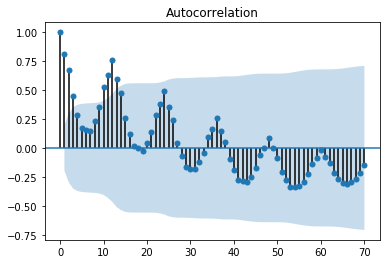

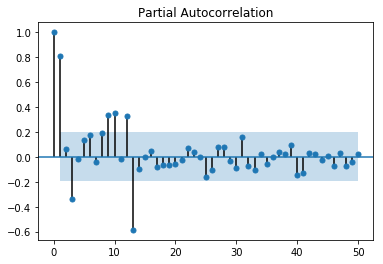

In [6]:
plot_acf(ZR,lags=70)
pyplot.show()

plot_pacf(ZR, lags=50)
pyplot.show()

In [4]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

# invert differenced value
def inverse_diff(history, yhat, interval):
    equal=list()
    for i in range(len(yhat)):
        value= yhat[i]+history[i]
        equal.append(value)
    return np.array(equal)

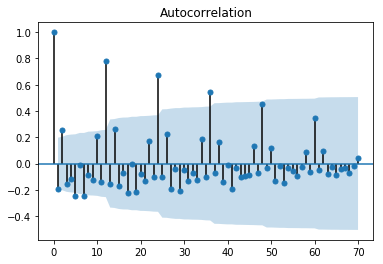

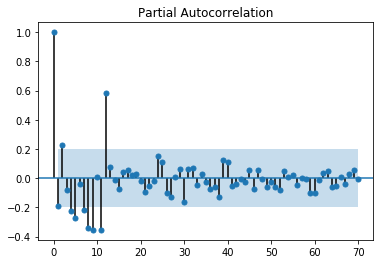

In [5]:
# Transformtion der Daten, da Saisonalität und Non-Stationarity vorhanden
# 1. log
ZR_log=np.log(ZR)

# 1.1 difference = 1
ZR_log_diff_1=difference(ZR_log,1)

# plot
plot_acf(ZR_log_diff_1,lags=70)
plot_pacf(ZR_log_diff_1,lags=70)
pyplot.show()

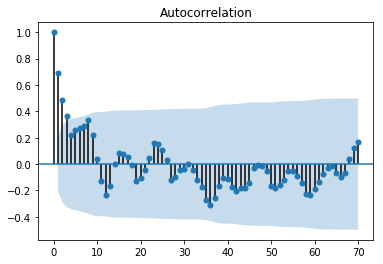

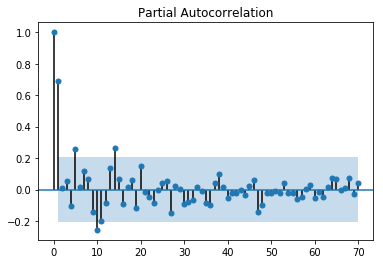

In [6]:
# 1.2 difference = 12
ZR_log_diff_12=difference(ZR_log,12)
plot_acf(ZR_log_diff_12,lags=70)
plot_pacf(ZR_log_diff_12,lags=70)
pyplot.show()

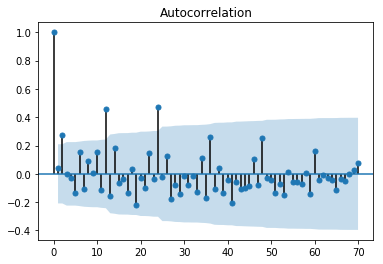

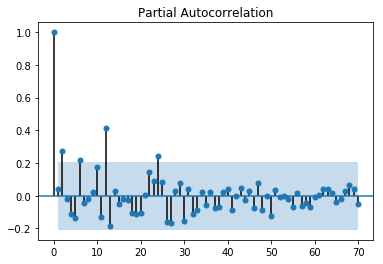

In [11]:
# 1.3: 1.1+1.2
ZR_log_diff=difference(ZR_log,12)+difference(ZR_log[:89],1)
plot_acf(ZR_log_diff,lags=70)
plot_pacf(ZR_log_diff,lags=70)
pyplot.show()

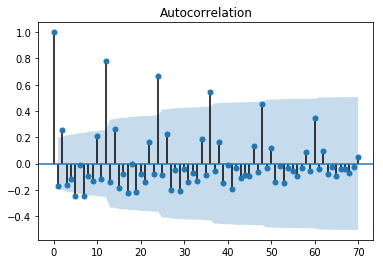

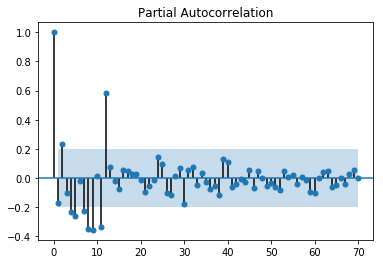

In [13]:
# 2. sqr
ZR_sqrt =np.sqrt(ZR)

#2.1 difference 1
ZR_sqrt_diff_1=difference(ZR_sqrt,1)
plot_acf(ZR_sqrt_diff_1,lags=70)
plot_pacf(ZR_sqrt_diff_1,lags=70)
pyplot.show()

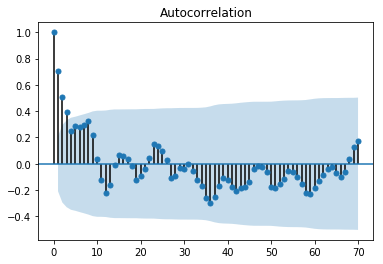

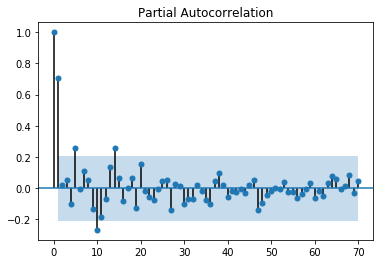

In [14]:
# 2.2 difference = 12
ZR_sqrt_diff_12=difference(ZR_sqrt,12)
plot_acf(ZR_sqrt_diff_12,lags=70)
plot_pacf(ZR_sqrt_diff_12,lags=70)
pyplot.show()

In [15]:
# testen, ob zr_log_diff stationär
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ZR_log_diff_12, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -3.425914
p-value                         0.010107
#Lags Used                     11.000000
Number of Observations Used    76.000000
dtype: float64


In [16]:
kpssoutput_c=kpss(ZR_log_diff_12,regression='c')
print(kpssoutput_c)

(0.24400557393126995, 0.1, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [7]:
# Modellordnungen testen
ZR_log_diff_12_f = ZR_log_diff_12 * 1.0
model = ARIMA(ZR_log_diff_12_f, order=(1,0,3))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   88
Model:                     ARMA(1, 3)   Log Likelihood                 198.475
Method:                       css-mle   S.D. of innovations              0.025
Date:                Wed, 05 Sep 2018   AIC                           -384.950
Time:                        16:32:11   BIC                           -370.086
Sample:                             0   HQIC                          -378.962
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0196      0.007      2.612      0.011       0.005       0.034
ar.L1.y        0.0600      0.327      0.184      0.855      -0.581       0.701
ma.L1.y        0.7527      0.311      2.424      0.0

In [ ]:
model = ARIMA(ZR_log_diff_12_f, order=(1,0,3))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

In [18]:
model = ARIMA(ZR_log_diff_12_f, order=(2,0,3))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   88
Model:                     ARMA(2, 3)   Log Likelihood                 198.851
Method:                       css-mle   S.D. of innovations              0.025
Date:                Sun, 26 Aug 2018   AIC                           -383.703
Time:                        15:44:35   BIC                           -366.362
Sample:                             0   HQIC                          -376.717
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.009      2.096      0.039       0.001       0.036
ar.L1.y        0.1628      0.297      0.548      0.585      -0.420       0.745
ar.L2.y        0.2334      0.250      0.935      0.3

In [19]:
model = ARIMA(ZR_log_diff_12_f, order=(5,0,3))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   88
Model:                     ARMA(5, 3)   Log Likelihood                 210.618
Method:                       css-mle   S.D. of innovations              0.021
Date:                Sun, 26 Aug 2018   AIC                           -401.237
Time:                        15:45:27   BIC                           -376.463
Sample:                             0   HQIC                          -391.256
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0137      0.019      0.714      0.477      -0.024       0.051
ar.L1.y        1.3993      0.178      7.852      0.000       1.050       1.749
ar.L2.y       -0.4505      0.382     -1.180      0.2

In [20]:
model = ARIMA(ZR_log_diff_12_f, order=(5,0,4))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   88
Model:                     ARMA(5, 4)   Log Likelihood                 213.561
Method:                       css-mle   S.D. of innovations              0.020
Date:                Sun, 26 Aug 2018   AIC                           -405.121
Time:                        15:45:36   BIC                           -377.871
Sample:                             0   HQIC                          -394.143
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0153      0.016      0.985      0.328      -0.015       0.046
ar.L1.y        1.1542      0.059     19.686      0.000       1.039       1.269
ar.L2.y       -0.5705      0.052    -10.997      0.0

In [8]:
model = ARIMA(ZR_log_diff_12_f, order=(1,0,2))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   88
Model:                     ARMA(1, 2)   Log Likelihood                 197.157
Method:                       css-mle   S.D. of innovations              0.026
Date:                Wed, 05 Sep 2018   AIC                           -384.314
Time:                        16:32:26   BIC                           -371.927
Sample:                             0   HQIC                          -379.323
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0164      0.013      1.214      0.228      -0.010       0.043
ar.L1.y        0.8807      0.095      9.244      0.000       0.694       1.067
ma.L1.y       -0.1203      0.149     -0.809      0.4

C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


In [8]:
# Vorhersage
# 0. Einteilen der transformierten Daten in Trainings-und Testdaten
# Transformierte Daten
length=int(len(ZR_log_diff_12)/2)
ZR_TR_P, ZR_TE_P= ZR_log_diff_12_f[0:length], ZR_log_diff_12_f[length:len(ZR_log_diff_12_f)]
ZR_TR_log, ZR_TE_log= ZR_log[0:length], ZR_log[length:len(ZR_log)]

# original Daten
# ZR abschneiden, da Differenzierung Datensatz verkleinert 
ZR_S=ZR[12:]
ZR_TR_S, ZR_TE_S= ZR_S[0:length], ZR_S[length:len(ZR)]

# ZR lassen, fürs re-processing
ZR_TR, ZR_TE=ZR[0:50], ZR[50:len(ZR)]

In [22]:
# 1. ARIMA(1,0,3) anpassen/ fit für Inputgröße von 50
model=ARIMA(ZR_TR_P, order=(1,0,2))
model_fit=model.fit(disp=0)

# Zusammenfassung des angepassten Modells
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   44
Model:                     ARMA(1, 2)   Log Likelihood                  99.853
Method:                       css-mle   S.D. of innovations              0.025
Date:                Sun, 26 Aug 2018   AIC                           -189.706
Time:                        15:46:08   BIC                           -180.785
Sample:                             0   HQIC                          -186.398
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0086      0.007      1.158      0.254      -0.006       0.023
ar.L1.y        0.4581      0.578      0.793      0.432      -0.674       1.590
ma.L1.y        0.3252      0.588      0.553      0.5

C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Anaconda\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=0.007421, expected=0.044166
predicted=0.007421, expected=0.041999
predicted=0.007421, expected=0.059142
predicted=0.007421, expected=0.041968
predicted=0.007421, expected=0.031808
predicted=0.007421, expected=0.035489
predicted=0.007421, expected=0.058001
predicted=0.007421, expected=0.057768
predicted=0.007421, expected=0.064533
predicted=0.007421, expected=0.033728
predicted=0.007421, expected=0.000075
predicted=0.007421, expected=0.037550
predicted=0.007421, expected=0.010734
predicted=0.007421, expected=0.029164
predicted=0.007421, expected=0.046959
predicted=0.007421, expected=0.018774
predicted=0.007421, expected=0.048496
predicted=0.007421, expected=0.039034
predicted=0.007421, expected=0.035094
predicted=0.007421, expected=0.039744
predicted=0.007421, expected=0.029207
predicted=0.007421, expected=0.048110
predicted=0.007421, expected=0.118757
Test MSE: 0.002


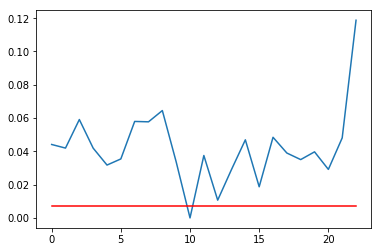

In [9]:
# 2. Vorhersage
# 2.1 t+1 
history = [x for x in ZR_TR_P]
model = ARIMA(history, order=(1,0,2))
model_fit = model.fit(disp=0)
predictions = list()
for t in range(len(ZR_TE_P)-21):
    model = ARIMA(history, order=(1,0,2))
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = ZR_TE_P[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(ZR_TE_P[:23], predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(ZR_TE_P[:23])
pyplot.plot(predictions, color='red')
pyplot.show()

In [11]:
# 3. Re-processing
# 3.1: t+1
# invert differenced value
predictions=inverse_diff(ZR_TE_log,predictions, 12)

# invert log
predictions=np.exp(predictions)

5894128.515341579


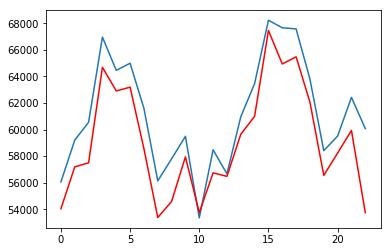

In [12]:
# 4. Bewertung: MSE
# 4.1 t+1
error= mean_squared_error(ZR_TE_S[:23],predictions)
print(error)
test=ZR_TE_S[:23]
pyplot.plot(test, color='blue')
pyplot.plot(predictions, color='red')
pyplot.show()